In [1]:
# Import Libraries and Dependencies
import matrix_games
from matrix_games.base import*
from matrix_games.generate import*

In [15]:
prob = mg_problem("rand", "simplex", "large")

In [2]:
dimN = 700
dimM = 300
q0 = np.ones(dimN + dimM)

A = create_A("rand", (dimN,dimM))
prob = mg_problem(A, "simplex")
F_mg, J_mg, J_mg_com, prox_g_mg = prob.get_parameters()

Adaptive Graal Implemntation

In [3]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list
def adaptive_graal_terminate(J, F, prox_g, x1, numb_iter=100, phi=1.5, tol=1e-6, output=False):
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    i = 1
    while i <= numb_iter and values[-1] > tol:
        i += 1
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = np.exp(np.log(n1) - np.log(n2))
        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2, 1e6)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)

        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)

    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, i


Solving the VI

In [4]:
N = 1000

# starting point
q0 = np.ones(dimN + dimM)

In [5]:
ans1 = adaptive_graal(J_mg, F_mg, prox_g_mg, q0, numb_iter=N, phi=1.5, output=False)

CPU time for aGRAAL: 5.326360500000001


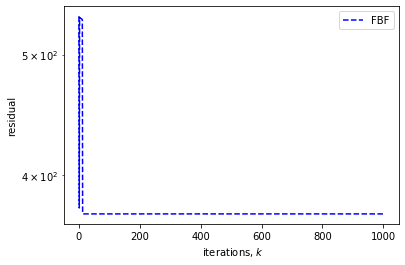

In [6]:
plt.plot(ans1[0], '--b', label = 'FBF')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

plt.legend()
#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()